In [1]:
import configparser

parser = configparser.ConfigParser()
parser.read('config.ini')

['config.ini']

In [8]:
import sys
import pandas as pd
import numpy as np
import os
import traceback
import pdb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
np.seterr(all="ignore")
plt.rcParams['text.usetex'] = True

#--- user libs
sys.path.append(parser['py library directory']['path'])
import utility as utl
import imp
imp.reload(utl)
import LammpsPostProcess2nd as lp
imp.reload(lp)

class Symbols:
    def __init__(self):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=[10,10,10,12,12,12,10]
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs
    
DRAW_FRAME=(0.23,0.08,0.12,0.07,0.1)


# Avalanche statistics

inputFiles= ['tensileCantor_tensile900_1_rate2.txt'
 'tensileCantor_tensile900_1_rate2.gz']
mkdir: png: File exists


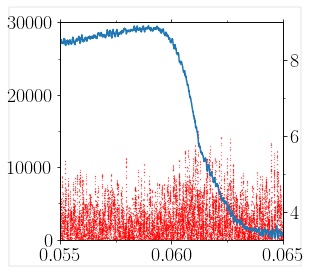

# of avalanches:563


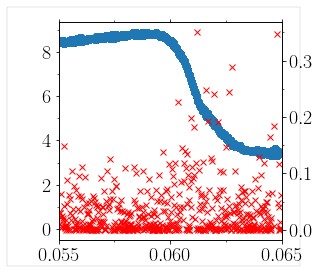

write in pdf_s.txt


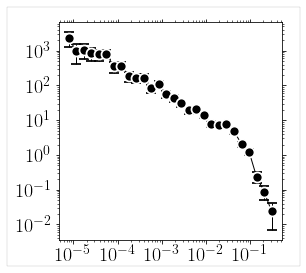

write in pdf_dur.txt


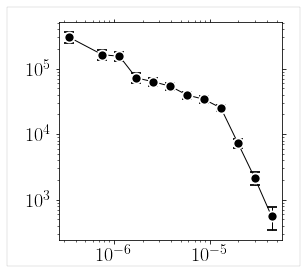

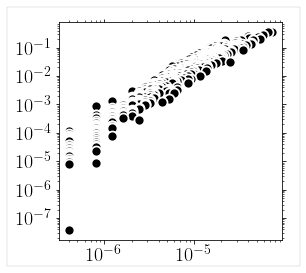

In [10]:
class Statistics:
    
    def __init__(self,path,verbose=False):

        self.path = path
        self.verbose = verbose
        
        #--- list of files
        self.inputFiles = os.listdir('%s'%(path))
        if self.verbose:
            print('inputFiles=',np.array(self.inputFiles))
            
            
    def ParseDump(self,indx):
        if self.verbose:
            print('parsing %s/%s:'%(self.path,self.inputFiles[indx]))
        self.lmpData = lp.ReadDumpFile('%s/%s'%(self.path,self.inputFiles[indx])) #,verbose=self.verbose)
        self.lmpData.GetCords(ncount=sys.maxsize)
        #--- print
        if self.verbose:
            keys = list(self.lmpData.coord_atoms_broken.keys())
            keys.sort()
            display(self.lmpData.coord_atoms_broken[keys[0]])
    
    def ParseTimeSeries(self,indx):    
        #--- read input file
        # loadTimeSeries=list(map(lambda x:pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(path,x))],
        #                 columns=['Time','Stress']),inputFiles))
        # loadTimeSeries[0] #--- index indicates the indenter location

        self.loadTimeSeries=pd.DataFrame(np.c_[np.loadtxt('%s/%s'%(self.path,self.inputFiles[indx]),max_rows=1000000)],
                        columns=['strain','press','szz','sxx','syy','sxy','syz','sxz','vol']
                                   )
    def PltTimeSeries(self):
        !mkdir png

        #--- set limits
        index = 0 #--- file index
        ld = self.loadTimeSeries#[ index ] #--- file id
        # indentLabel, grainID = GetGrainId(indent,indentLabels,loadID,index)
        # print('indent label:%s, grain id:%s'%(indentLabel,grainID))

        #--- time
        tlo = 0.06-0.01/2 #ld.Time.min()
        thi = 0.06+0.01/2 #ld.strain.max() #ld.Time.max()
        filtr=np.all([ld['strain']<thi,ld['strain']>=tlo],axis=0)
        # #--- load
        flo = 0.99*ld['szz'][filtr].min()
        fhi = 1.01*ld['szz'][filtr].max() #ld.Force.max()

        #--- rate
        rate = -np.gradient(ld.szz,ld.strain)
        filtr = rate > 0


        ax=utl.PltErr(None,None,Plot=False)

        utl.PltErr(ld.strain[filtr], rate[filtr],
                   attrs={'fmt':'.','color':'red','ms':.4},
                    Plot=False,
                      ax=ax,
        #           yscale='log',
                    xlim=(tlo,thi),
                    ylim=(0,3e4),

                  )

        #--- load vs. time
        utl.PltErr(ld.strain, ld.szz,
                   attrs={'fmt':'-','color':'C0'},
        #             Plot=False,
                    xlim=(tlo,thi),
                    ylim=(flo,fhi),
                   ax=ax,
                      twinx=True,
                    title='png/stress_timeseries.png',
                   DrawFrame=DRAW_FRAME,
                  )
    @staticmethod
    def GetAvl( t,x, y, lambdc ):
        n = len(x)
        i = 0
        smat = [[],[],[],[],[]]
        try:
            while True:
                while y[i] < lambdc:
                    i += 1
                assert y[i] >= lambdc
                #--- avalanche starts
                dur = 0
    #            size = 0.0 #y[i]
                start = x[i]
                start_indx = i
                start_t = t[i]
                while y[i]>=lambdc: #-x[i] == 1:
                    dur += 1
    #                size += (y[i]-lambdc)
                    i += 1
                #--- avalanche ends
                assert y[i] < lambdc
                end = x[i] #x[i-1 if i-1 >= 0 else 0]
                end_indx = i #i-1 if i-1>= 0 else 0
                end_t = t[i] #i-1 if i-1>= 0 else 0
                #--- size
                sub_x = x[start_indx:end_indx+1]
                sub_y = y[start_indx:end_indx+1]
                size = np.sum((sub_x[1:]-sub_x[:-1])*sub_y[:-1])
    #            print start, end, size
                #--- find epicenter
                smat = np.c_[smat,[start, end, start_t, end_t, size]]
        except:
    #        traceback.print_exc()
            pass

        assert smat.shape[1] > 0, 'Lower lambdc! lambdc='%lambdc
        df_avl = pd.DataFrame(smat.T,columns=['ei','ef','ti','tf','size'])
        df_avl=df_avl[df_avl['size']>0]
        return df_avl
    
    @staticmethod
    def Wrapper_GetAvl(t,x,y,tlo,thi,lambdc):
        '''
        return avalanche sizes given force timeseries and initial and final times
        '''

    #    print(np.min(GetPower(ld,tlo,thi)))

        #--- data frame storing avalanche attributes
        filtr = np.all([x>tlo,x<thi],axis=0)

        df_avl = Statistics.GetAvl( t,np.array(x[filtr]), -np.gradient(y,x)[filtr], lambdc)
        print('# of avalanches:%s'%df_avl.shape[0])
        #df_avl = GetAvalKunMethod( broken_bonds,  5) #tcrltn )

        #--- save
        # df_fltrd = DataFrameSubSet( df_avl, #--- filter
        #                               'ti', 
        #                               ( 0, tavl ) ) 
        # df_fltrd.to_pickle('df_avl.pk')

        df_avl.sort_values( by = 'size',ascending = False,inplace=True)
    #    print ('n.avls = %s'%len(df_avl))
        return df_avl #np.array(df_avl['size'].to_list())

    def Avalanche(self,    
        lambdc = 0.0, #--- threshold
    #    temps=['900'] #'300','700','900','600','800']
        #tlo = 0.0
        #thi = dmpStrs.strain.max()
        tlo = 0.06-0.01/2, #ld.Time.min()
        thi = 0.06+0.01/2, #ld.strain.max() #ld.Time.max()
                 ):

        try:
            df_avl = list(map(lambda x:Statistics.Wrapper_GetAvl(list(x.index),x.strain,x.szz,tlo,thi,lambdc),\
                              [self.loadTimeSeries]))
        #    df_avl = dict(zip(temps,list(map(lambda x:Wrapper_GetAvl(x.timestep,x.strain,x.szz,tlo,thi,lambdc), [dmpStrs]))))
        #    print('df_avl.shape:%s'%df_avl['300'].shape[0])
        #    df_avl = Wrapper_GetAvl(ld,tlo,thi,lambdc)
        except:
            traceback.print_exc()
            print('increase the threshold')


        self.df_avl = df_avl[0]
        symbols=Symbols()
        
        #--- plot stress timeseries
        ax=utl.PltErr(self.loadTimeSeries.strain,self.loadTimeSeries.szz,#dmpStrs.strain,dmpStrs.szz,
        #            attrs=symbols.GetAttrs(count=0),
                      Plot=False,
                    xlim=(tlo,thi),
        #           xstr=r'$\epsilon_{zz}$',
        #           ystr=r'$\sigma_{zz}$(Gpa)',
        #            ylim=(2,3)
                  )
        
        #--- plot stress drops
        utl.PltErr(self.df_avl['ef'],self.df_avl['size'],
                   attrs={'fmt':'x','color':'red'},
                     xlim=(tlo,thi),
        #            ylim=(flo,fhi),
                   ax=ax.twinx(),
#                    yscale='log',
                   DrawFrame=DRAW_FRAME,
                   title='png/size.png'
                  )

    def SizeDist(self,sizes, fout, **kwargs):
        ax = utl.PltErr(None,None,Plot=False)
        symbols=Symbols()
        legend=Legends()
        legend.Set(fontsize=20,
                         labelspacing=0,
                         bbox_to_anchor=(.9,0.48,0.5,0.5),
                   )

        alpha=1.0
        count=0
        temp='900'
    #    for count,temp in zip(range(len(df_avl)),['900']): #--- different temperatures
#        sizes = self.df_avl['size']
        smax = np.max(sizes)
        hist, edge, err = utl.GetPDF(sizes, n_per_decade=6, linscale=None)
        
        with open('avlStats/%s'%fout,'w') as fp:
            np.savetxt(fp,np.c_[hist, edge, err],header='hist edge err')
        if self.verbose:
            print('write in %s'%fout)
        
        utl.PltErr(edge, 
                   10**count*hist,#*edge**alpha, 
                   yerr=10**count*err,#*edge**alpha,
                   Plot=False,ax=ax,
                   attrs=symbols.GetAttrs(count=count,label=r'$%s$'%temp),
                  )

        utl.PltErr(None, None,
                   ax=ax,
                   **kwargs,
                   DrawFrame=DRAW_FRAME,
                   #legend=legend.Get()
                  )
    
    def Scatter(self,x,y,fout,**kwargs):
        symbols=Symbols()
        utl.PltErr(x,
                   y,
                  attrs= symbols.GetAttrs(count=0,fmt='.'),
                   DrawFrame=DRAW_FRAME,
                   **kwargs,
                  )
        with open('avlStats/%s'%fout,'w') as fp:
            np.savetxt(fp,np.c_[x, y],header='size duration')

def main():
    !mkdir avlStats
    
    #--- call constructor
    stats = Statistics(path = parser['test data directory']['path'],verbose=True)

    #--- parse dump file
    #stats.ParseDump(indx=0)

    #--- parse timeseries
    stats.ParseTimeSeries(indx=0)

    #--- plot timeseries
    stats.PltTimeSeries()

    #--- get avalanches
    stats.Avalanche()

    #--- size distribution
    stats.SizeDist(sizes=stats.df_avl['size'],
                   fout='pdf_s.txt',
                        attrs={'fmt':'-.r'},
                       xscale = 'log',
                       yscale='log',
            #           xlim=(1.0e-6,.2),
            #           ylim=(1e-1,1e8),,
                       title='png/ps.png',
    )

    #--- duration
    stats.SizeDist(sizes = stats.df_avl['ef']-stats.df_avl['ei'],
                   fout='pdf_dur.txt',
                        attrs={'fmt':'-.r'},
                       xscale = 'log',
                       yscale='log',
            #           xlim=(1.0e-6,.2),
            #           ylim=(1e-1,1e8),,
                       title='png/pt.png',
                  )

    #--- size vs. duration
    stats.Scatter(stats.df_avl['ef']-stats.df_avl['ei'],
                 stats.df_avl['size'],
                  fout='scatter_st.txt',
                  xscale='log',yscale='log',
                       title='png/scatter_st.png',

                 )
    
main()

## load curve (dump file)

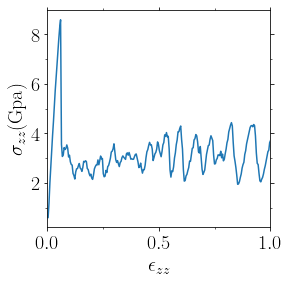

<AxesSubplot:xlabel='$\\epsilon_{zz}$', ylabel='$\\sigma_{zz}(\\mathrm{Gpa})$'>

In [7]:
# #--- timesteps
# keys = list(lmpData.coord_atoms_broken.keys())
# keys.sort()

# #--- stress
# szz = list(map(lambda x:lmpData.coord_atoms_broken[x]['c_mystress[3]'].sum(),keys))

# #--- strain
# box = lp.Box(BoxBounds=lmpData.BoxBounds[keys[0]],
#       AddMissing=np.array([0,0,0])
#       )

# lz0 = box.CellVector[2,2]
# ezz = list(map(lambda x:lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1,
#                keys))

# #--- volume
# vol = list(map(lambda x:np.linalg.det(lp.Box(BoxBounds=lmpData.BoxBounds[x],AddMissing=np.array([0,0,0])).CellVector),
#                keys))

# dmpStrs=pd.DataFrame(np.c_[keys,np.array(ezz+ezz[1]-ezz[0]),1e-4*np.array(szz)/vol],columns=['timestep','strain','szz'])

# #--- plot
# symbols=Symbols()
# ax=utl.PltErr(None,#loadTimeSeries['strain'],
#           None,#loadTimeSeries['szz'],
#            fmt='-',
#               Plot=False,
          
#           )
# utl.PltErr(dmpStrs.strain,dmpStrs.szz,
# #            attrs=symbols.GetAttrs(count=0,fmt='.-'),
#            attrs={'fmt':'-','color':'C0'},
#           ax=ax,
#             xlim=(0.0,1.0),
# #            ylim=(2,3)
#            xstr=r'$\epsilon_{zz}$',
#            ystr=r'$\sigma_{zz}(\mathrm{Gpa})$',
#            title='png/stress_strain.png'
#           )



### strain map

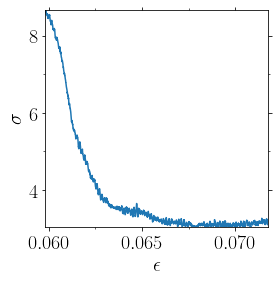

<AxesSubplot:xlabel='$\\epsilon$', ylabel='$\\sigma$'>

In [10]:
# #--- strain window
# tif=df_avl.iloc[0][['ei','ef']]
# filtr=np.all([dmpStrs['strain']<tif['ef'],dmpStrs['strain']>=tif['ei']],axis=0)
# # #--- load
# flo = 0.99*dmpStrs['szz'][filtr].min()
# fhi = 1.01*dmpStrs['szz'][filtr].max() #ld.Force.max()

# #--- load vs. time
# ydata = loadTimeSeries
# utl.PltErr(ydata.strain, ydata.szz,
#            attrs={'fmt':'-'},
#             xlim=(tif['ei'],tif['ef']),
#             ylim=(flo,fhi),
#            xstr=r'$\epsilon$',
#            ystr=r'$\sigma$',
#           )

### local strain

In [11]:
# def WrapperStrain(lmpData,reference_frames,current_frames, dim=3):
#     '''
#     invoke strain analysis in ovito
#     '''
#     #--- split dump file
#     for ii0, ii in zip(reference_frames,current_frames):
#         atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
#         atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
#         box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
#         box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
#         lp.WriteDumpFile(atom_current, box).Write('strain/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')

#         lp.WriteDumpFile(atom_reference, box0).Write('strain/dump_ref.xyz', itime=ii0,
#              attrs=['id', 'type','x', 'y', 'z'],
#              fmt='%i %i %15.14e %15.14e %15.14e')
#         fileCurr = 'strain/dump_curr.xyz'
#         fileRef = 'strain/dump_ref.xyz'
#         output = 'strain/d2min.%s.xyz'%ii
#         #--- load to ovito
#         os.system('ovitos %s/OvitosCna.py %s %s 2 5 %s'%(parser['py library directory']['path'],
#                                                          fileCurr,output,fileRef))
#         #--- concat
#         os.system('cat %s >> strain/strain.xyz;rm %s'%(output,output))

        
# !mkdir strain
# try:
#     os.system('rm strain/strain.xyz')
# except:
#     pass
# #--- current
# current_frames = np.c_[df_avl['tf']].astype(int).flatten()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
# print('reference_frames=',reference_frames)

# #--- call function
# WrapperStrain(lmpData,reference_frames,current_frames)

# #--- parse
# lmpStrn = lp.ReadDumpFile( 'strain/strain.xyz' )
# lmpStrn.GetCords( ncount = sys.maxsize )

mkdir: cannot create directory ‘strain’: File exists
current_frames= [ 280000 2770000 2250000 2500000 1650000 3340000 3720000 3420000 3650000
 1500000  410000 1990000 3050000 1860000 3930000  750000  910000  610000
 1810000 1300000 2970000 1140000 1380000 2910000 2090000 1180000  490000
 1070000  980000 1010000 2410000 3580000  310000 2040000  690000]
reference_frames= [ 250000 2660000 2170000 2430000 1600000 3270000 3660000 3370000 3600000
 1440000  330000 1950000 3010000 1820000 3890000  710000  850000  540000
 1780000 1260000 2930000 1100000 1350000 2880000 2050000 1150000  460000
 1020000  960000 1000000 2400000 3570000  300000 2030000  680000]
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.280000.xyz
nevery 2
InputFile= strain/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.2770000.xyz
nevery 2
InputFile= strain/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= strain/dump_curr.xyz
OutputFile= strain/d2min.2250000.xyz
nevery 

### d2min

In [12]:
# def WrapperD2min(lmpData,reference_frames,current_frames, dim=3):
#     '''
#     invoke d2min analysis in ovito
#     '''
#     #--- split dump file
#     for ii0, ii in zip(reference_frames,current_frames):
#         atom_current = lp.Atoms(**lmpData.coord_atoms_broken[ii])
#         atom_reference = lp.Atoms(**lmpData.coord_atoms_broken[ii0])
#         box  = lp.Box( BoxBounds = lmpData.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
#         box0 = lp.Box( BoxBounds = lmpData.BoxBounds[ii0], AddMissing = np.array([0.0,0.0,0.0] ))
#         if dim == 3:
#             lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')
#             lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
#                  attrs=['id', 'type','x', 'y', 'z'],
#                  fmt='%i %i %15.14e %15.14e %15.14e')
#         else:
#             lp.WriteDumpFile(atom_current, box).Write('D2minAnl/dump_curr.xyz', itime = ii,
#                  attrs=['id', 'type','x', 'y'],
#                  fmt='%i %i %15.14e %15.14e')
#             lp.WriteDumpFile(atom_reference, box0).Write('D2minAnl/dump_ref.xyz', itime=ii0,
#                  attrs=['id', 'type','x', 'y'],
#                  fmt='%i %i %15.14e %15.14e')
#     #    os.system('tar czf dump.gz dump.xyz')
#         fileCurr = 'D2minAnl/dump_curr.xyz'
#         fileRef = 'D2minAnl/dump_ref.xyz'
#         output = 'D2minAnl/d2min.%s.xyz'%ii
#         #--- load to ovito
#         os.system('ovitos %s/OvitosCna.py %s %s 2 2 %s'%(parser['py library directory']['path'],
#                                                          fileCurr,output,fileRef))
#         #--- concat
#         os.system('cat %s >> D2minAnl/d2min.xyz;rm %s'%(output,output))

        
        
        
# #    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease nevery!'
# !mkdir D2minAnl
# try:
#     os.system('rm D2minAnl/d2min.xyz')
# except:
#     pass

# #--- assign frames
# #--- current
# current_frames = np.c_[df_avl['tf']].astype(int).flatten()
# print('current_frames=',current_frames)
# #--- reference
# reference_frames = np.c_[[df_avl['ti']]].astype(int).flatten()
# print('reference_frames=',reference_frames)

# #--- call function
# WrapperD2min(lmpData,reference_frames,current_frames)
# #--- parse
# lmpDmin = lp.ReadDumpFile( 'D2minAnl/d2min.xyz' )
# lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

mkdir: cannot create directory ‘D2minAnl’: File exists
current_frames= [ 280000 2770000 2250000 2500000 1650000 3340000 3720000 3420000 3650000
 1500000  410000 1990000 3050000 1860000 3930000  750000  910000  610000
 1810000 1300000 2970000 1140000 1380000 2910000 2090000 1180000  490000
 1070000  980000 1010000 2410000 3580000  310000 2040000  690000]
reference_frames= [ 250000 2660000 2170000 2430000 1600000 3270000 3660000 3370000 3600000
 1440000  330000 1950000 3010000 1820000 3890000  710000  850000  540000
 1780000 1260000 2930000 1100000 1350000 2880000 2050000 1150000  460000
 1020000  960000 1000000 2400000 3570000  300000 2030000  680000]
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.280000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2770000.xyz
nevery 2
InputFile= D2minAnl/dump_curr.xyz
num_frames= 1
frame=0/1
InputFile= D2minAnl/dump_curr.xyz
OutputFile= D2minAnl/d2min.2

### plot

In [13]:
# def quantile(slist,q):
#     slist.sort()
#     n=len(slist)
#     return slist[int(q*n):][0]


# #--- print 
# !rm D2minAnl/d2min_avalanche.xyz
# keys=list(lmpDmin.coord_atoms_broken.keys())
# keys.sort()
# sfile=open('D2minAnl/d2min_avalanche.xyz','a')
# for time in keys:
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
# sfile.close()

### vary threshold

# of avalanches:726
# of avalanches:726
# of avalanches:728
# of avalanches:728
# of avalanches:718
# of avalanches:391


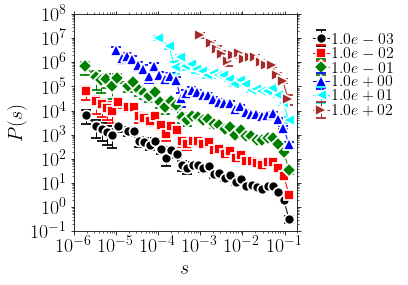

<AxesSubplot:xlabel='$s$', ylabel='$P(s)$'>

In [186]:
# def varyThreshold(loadTimeSeries, tlo, thi, lambdc):
#     return np.concatenate(list(map(lambda x:Wrapper_GetAvl(x,tlo,thi,lambdc)['size'], loadTimeSeries)))

# legend=Legends()
# legend.Set(fontsize=16,
#                  labelspacing=0,
#                  bbox_to_anchor=(1,0.48,0.5,0.5),
#            )
# #
# alpha=1.0
# #
# lambdc = np.logspace(np.log10(1.0e-3),np.log10(1.0e2),6)
# size_lambdc = list(map(lambda x:varyThreshold([loadTimeSeries[0]], tlo, thi, x),lambdc))

# #--- distributions
# hists = list(map(lambda x: utl.GetPDF(x, n_per_decade=8, linscale=None), size_lambdc))

# ax = utl.PltErr(None,None,Plot=False)
# for item, threshold, indx in zip(hists, lambdc, range(len(hists))):
#     hist, edge, err = item
#     ax=utl.PltErr(edge, 
#                   10**indx*hist,#*edge**alpha, 
#                   yerr=10**indx*err,#*edge**alpha,
#                    attrs=symbols.GetAttrs(count=indx%7,label=r'$%2.1e$'%threshold),
#                     Plot = False,
#                     ax=ax,
#                   )
# utl.PltErr(None,None,
# #    edge, 1e-1/edge**alpha,
# #           attrs={'fmt':'-.r'},
#             legend=legend.Get(),
# #           ystr=r'$P(s).s^{%s}$'%alpha,xstr=r'$s$',
#            ystr=r'$P(s)$',xstr=r'$s$',
#            xscale = 'log',yscale='log',
#            xlim=(1.0e-6,.2),ylim=(1e-1,1e8), #hist.min(),hist.min()*1e8),
#            ax=ax,
#            title='png/ps.png',
#           )

[ 1.25007966 -0.53496973 12.76198166]


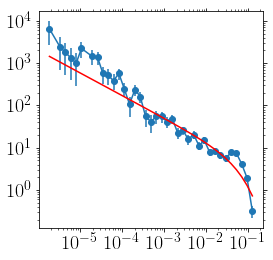

<AxesSubplot:>

In [170]:
# def func(x, a, b, c):
#     return a * x**b * np.exp(-c * x)
# def func2(x, a, b):
#     return a * x**b

# xdata = edge
# ydata = hist
# yerr=err
# ax = utl.PltErr(xdata, ydata, yerr=yerr, label='data',Plot=False)
# popt, pcov = curve_fit(func, xdata, ydata,
#                       bounds=((1e-3,-4,1e-3), (np.infty, 0, 100.0)),
#                        p0=(1,-1,10.0),
#                        sigma=err,
#                       )
# print(popt)
# utl.PltErr(xdata, func(xdata, *popt), attrs={'fmt':'r-'},
#          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt),
#         ax=ax,
#            xscale='log',yscale='log',
#           )



In [348]:
# input_file = '/Users/Home/Desktop/Tmp/txt/git/DislocationAvalanches/nanoindentation/ebsd/attributes.txt'
# grain_attr = pd.read_csv(input_file,sep='\t')
# grain_attr.head()

,#grainID,x,y,grainSize,perimeter,boundarySize,numNeighbors
0,1,-0.018954,0.068387,1,3.695012,5,1
1,2,-85.909030,-0.799994,1,2.771259,6,1
2,3,-85.909030,-2.399981,1,2.771259,6,2
3,4,-141.335700,-0.852774,10,13.056300,24,3
4,5,-85.909030,-3.199974,1,2.771259,6,3


In [349]:
# def Wrapper(index):
#     #index = 0 #--- file index
#     ld = loadTimeSeries[ index ] #--- file id
#     indentLabel = indentLabels[index]

#     grainLabel = grainLabels[loadID][indentLabel]
#     print('indent label:%s, grain label:%s'%(indentLabel,grainLabel))

#     lambdc = 10.0
#     avlanche = Wrapper_GetAvl(ld,tlo,thi,lambdc)
#     moment_1st = np.mean(avlanche)
#     avalanche_sq = avlanche*avlanche
#     moment_2nd = np.mean(avalanche_sq)**0.5
#     avalanche_4th = avalanche_sq*avalanche_sq
#     moment_4th = np.mean(avalanche_4th)**0.25

#     grainSize = grain_attr[ grain_attr['#grainID'] == grainLabel ].grainSize
# #    pdb.set_trace()
#     return grainSize.iloc[0], moment_1st, moment_2nd, moment_4th


# #val = np.c_[list(map(lambda x:Wrapper(x),range(len(loadTimeSeries))))]
# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,1]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'1st moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )

# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,2]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'2nd moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )
# # utl.PltErr(val[:,0],val[:,2],
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'avalanche size(2nd moment)',
# #            title='avalancheSize.png'
# # #           xlim=(-3,3),
# # #           ylim=(-3,3),
# #           )

# # utl.PltErr(utl.Zscore(val[:,0]),utl.Zscore(val[:,3]),
# #           attrs={'fmt' : '.',
# #           'markersize':10.0},
# #             xstr=r'grain size',
# #             ystr=r'4th moment',
# #            xlim=(-3,3),
# #            ylim=(-3,3),
# #           )


# cluster analysis
+ cluster analysis of top 5% atoms with largest D2min values 

In [21]:
# class Fractal:
#     '''
#     multi-fractal analysis of clusters
#     '''
#     def __init__(self, lmpDmin, lmpData, verbose = False):
#         '''
#         constructor
#         '''
#         self.lmpDmin = lmpDmin
#         self.lmpData = lmpData
#         self.verbose = verbose
        
#         !mkdir fractal
#         pass
    
#     def GetBitmaps(self,times, Plot=False):
#         '''
#         returns a binary matrix of clusters
#         '''
#         #--- loop over timesteps
#         for time in times:
#             #--- fetch data
#             dmin_log = np.log10(self.lmpDmin.coord_atoms_broken[time].d2min)
#             atom = lp.Atoms(**(self.lmpDmin.coord_atoms_broken[time]))
#             box  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#             atom.NonaffineSquaredDisplacement = list(dmin_log)
#              #-----------------
#              #--- INTERPOLATE
#              #-----------------
#             (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = utl.Intrp(atom, box, 'NonaffineSquaredDisplacement',
#                         Plot = None,
#                        )
#             #--- plot
#             value = utl.PltBinary(
#                                 xlin,ylin,zlin, mu_intrp.NonaffineSquaredDisplacement,
#                                 box,
#                                 0.0, #--- threshold
#                                 cmap='Greys',
#             #                    title='ModuAnl/negative_mu.%s.png'%itime,
#                                 zscore=False,
#                                 #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                                 xlabel = 'x', ylabel = 'y',
#                                 labels = True,
#                                 Plot=Plot,
#                              )
#             if self.verbose:
#                 print('value.shape=',value.shape)

#             #---------------------
#             #--- output matrix
#             #---------------------
#             mask = value >= quantile(list(value.flatten()),0.95)
#             if self.verbose:
#                 print('p=',np.sum(mask)/value.size)
#             #--- save
#             np.save('fractal/negative_mu%s'%time,mask)
#             np.savetxt('fractal/xlin%s.txt'%time,np.c_[xlin,],header='xlin')
#             np.savetxt('fractal/ylin%s.txt'%time,np.c_[ylin,],header='ylin')
#             np.savetxt('fractal/zlin%s.txt'%time,np.c_[zlin,],header='zlin')
            
#     def Strain(self,itime0,itime):
#         #--- strain
#         box = lp.Box(BoxBounds=self.lmpData.BoxBounds[itime0],
#           AddMissing=np.array([0,0,0])
#           )

#         lz0 = box.CellVector[2,2]
#         return lp.Box(BoxBounds=lmpData.BoxBounds[itime],
#                           AddMissing=np.array([0,0,0])).CellVector[2,2]/lz0-1
               
        
    
#     def func(self,x, a, b):
#         return b * x ** a

#     def FractalDimension(self,pathh,times,Plot=False):
#         '''
#         returns fractal dimension df
#         '''
#         itime0 = np.min(list(self.lmpData.coord_atoms_broken.keys()))
#         times.sort()
#         Df = []
#         strain= []
#         for time in times:
#             stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                              xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                              ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                              zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                             )
#             stats.GetSize()
#             stats.GetProbInf()
#             stats.GetProb()
#             stats.GetSmean()
#             stats.GetCrltnLenSq()
            
#             #--- fit
#             stats.stats.sort_values(by='rg_sq',inplace=True)
            
#             xdata = stats.stats['rg_sq']**0.5
#             ydata = stats.stats['size']
#             filtr = xdata > 0
# #             popt, pcov = curve_fit(self.func, xdata[filtr], ydata[filtr],
# #                                    bounds=((0,0),(np.inf,3))
# #                                   )
#             popt = np.polyfit(np.log10(xdata[filtr]), np.log10(ydata[filtr]),
#                                    1
#                                   )
#             popt[1] = 10 ** popt[1]
#             Df += [popt[0]]
#             if self.verbose:
#                 print('df=',popt[0])



#             #--- plot
#             if Plot:
#                 ax=utl.PltErr(xdata,ydata,
#                           attrs={'fmt':'.'},
#                               Plot=False,
#                           )
#                 utl.PltErr(xdata,self.func(xdata, *popt),
#                           attrs={'fmt':'r-.'},
#                           ax=ax,
#                            xscale='log',
#                            yscale='log',
#                            xstr=r'$r_g$',
#                            ystr=r'$s$',
#                            title='fractal/scatter_s_rg.png'
#                           )
                
#             strain += [self.Strain(itime0,time)]    
                
#         utl.PltErr(strain,Df,
#                   xstr=r'$\epsilon_{zz}$',
#                    ystr=r'$d_f$',
#                     title='fractal/df_strain.png'
#                   )

#     def GetStrsDrop(self,pathh,times):
#         '''
#         returns scatter data of stress drop and size
#         '''
#         sd=[]
#         volume=[]
#         for time in times:
#                 stats = utl.Stats(mask=np.load('%s/negative_mu%s.npy'%(pathh,time)), 
#                                  xlin=np.loadtxt('%s/xlin%s.txt'%(pathh,time)), 
#                                  ylin=np.loadtxt('%s/ylin%s.txt'%(pathh,time)),
#                                  zlin=np.loadtxt('%s/zlin%s.txt'%(pathh,time)),
#                                 )
#                 stats.GetSize()
#                 stats.GetProbInf()
#                 stats.GetProb()
#                 stats.GetSmean()
#                 stats.GetCrltnLenSq()

#                 vol  = lp.Box( BoxBounds = self.lmpData.BoxBounds[time],  
#                               AddMissing = np.array([0.0,0.0,0.0] )).GetVolume()

                
#                 sd += [vol*df_avl[df_avl['tf'] == time].iloc[0]['size']] #--- stress drop*vol
#                 volume += [stats.stats['size'].sum()]
#         #--- plot
#         ax=utl.PltErr(volume,sd,
#                   attrs={'fmt':'.'},
#                       Plot=False,
#                   )
#         utl.PltErr(None,None,#volume,volume,
#                   attrs={'fmt':'r-.'},
#                   ax=ax,
#                    xscale='log',
#                    yscale='log',
#                        ystr=r'$\Delta\sigma$',
#                        xstr=r'$s$',
# #                   xlim=(10**np.floor(np.log10(np.min(volume))),10**np.ceil(np.log10(np.min(volume))))
#                   )
    



mkdir: cannot create directory ‘fractal’: File exists
df= 1.9587480814301905


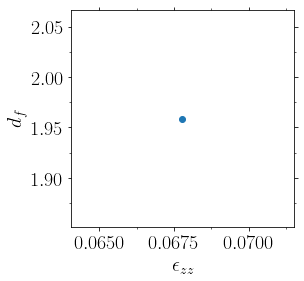

In [32]:
# fractal = Fractal(lmpDmin, lmpData, verbose = True)
# # fractal.GetBitmaps(
# #                     [280000],#list(lmpDmin.coord_atoms_broken.keys())[0:1],
# #                     Plot=True)
# fractal.FractalDimension('cantor/rate2nd/Run2/fractal',
#                          [280000],#list(lmpDmin.coord_atoms_broken.keys()),
#                          Plot=False,
#                         )
# # fractal.GetStrsDrop('cantor/rate2nd/Run2/fractal',
# #                     list(lmpDmin.coord_atoms_broken.keys())
# #                    )


In [63]:
# df = pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),mask.flatten()],columns=['x','y','z','mass'])
# utl.PrintOvito( df,
#                open('ovito.xyz','w'),
#                'itime=0',
#                 attr_list=['x', 'y', 'z','mass'],

#             )

In [64]:
#     sfile=open('dump.xyz','w')
#     dmin_log = np.log10(lmpDmin.coord_atoms_broken[time].d2min)
#     filtr = dmin_log >= quantile(list(dmin_log),0.95)
#     atom = lp.Atoms(**(lmpDmin.coord_atoms_broken[time][filtr]))
#     box  = lp.Box( BoxBounds = lmpData.BoxBounds[time],  AddMissing = np.array([0.0,0.0,0.0] ))
#     atom.NonaffineSquaredDisplacement = list(dmin_log[filtr])
        
#     #
#     lp.WriteDumpFile(atom, box).Write(sfile, itime = time,
#          attrs=['id', 'type','x', 'y', 'z','NonaffineSquaredDisplacement'],
#          fmt='%i %i %f %f %f %f')
#     sfile.close()